In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2 as cv
import pyvista as pv
import imageio
import pyMRAW

c:\Users\kristofc\Anaconda3\lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 150000, Original total frame: 621319)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


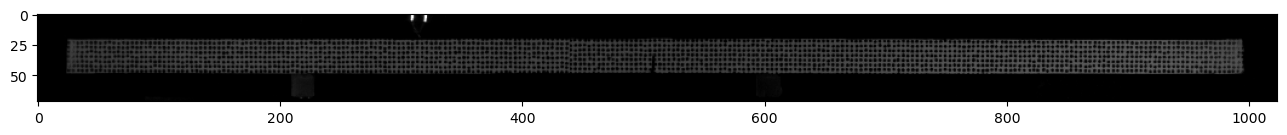

In [2]:
file = "C:\\Users\\kristofc\\Doktorat\\Podatki\\20201011_Nosilec_zareza_speckle\\video_001.cihx"

video = pyMRAW.load_video(file)
cih = video[1]
cih

plt.rcParams['figure.figsize'] = (16,6)

fig = video[0][0]#[:150000,:,25:995]

plt.imshow(fig, 'gray')

In [3]:
vect_0 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_0.txt")
vect_1 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_1.txt")
coord  = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\coord.txt")

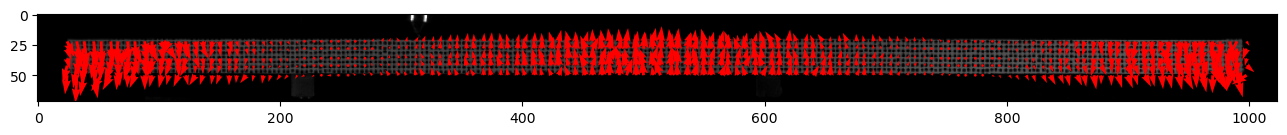

In [4]:
mode_0 = vect_0[0,:]
mode_1 = vect_1[0,:]

plt.imshow(fig, 'gray')
# plt.scatter(coord[:,1], coord[:,0])
plt.quiver(coord[:,1], coord[:,0], mode_1, mode_0, color = 'r', scale = 1.1)

In [97]:
mesh = pv.PolyData(np.column_stack((coord[:,1], coord[:,0], np.zeros(coord.shape[0]))))

shell = mesh.delaunay_2d()

vect = np.column_stack((mode_1, -mode_0, np.ones(mode_0.shape) * 0.01))

shell.add_field_data(vect, "vectors")
shell_def = shell.warp_by_vector(vectors="vectors", factor = 500)

In [48]:
pl = pv.Plotter(notebook=False)
pl.add_axes()
pl.add_mesh(shell, show_edges=True, color='blue', opacity=0.5)
pl.add_mesh(shell_def, show_edges=True)
pl.camera_position = 'xy'
pl.show()

# shell.plot(notebook=False, show_edges = True, cpos='xy')
# shell_def.plot(notebook=False, show_edges = True, cpos='xy')

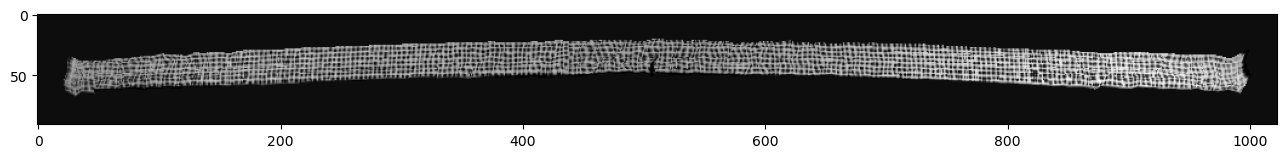

In [98]:
def init_output_image(input_image, coord):
    # Find the dimensions of the input image
    input_height, input_width = input_image.shape[:2]

    # Calculate the distances between mesh nodes and image edges
    distances = np.array([
        coord[:, 1],           # Distances to the left edge
        coord[:, 0],           # Distances to the top edge
        input_width - coord[:, 1],  # Distances to the right edge
        input_height - coord[:, 0]  # Distances to the bottom edge
    ])
    
    # Calculate the minimum distance from the edges
    min_distance = np.min(distances)
    
    # Calculate the minimum and maximum of the deformed mesh nodes
    min_x = np.min(shell_def.points[:,0])
    max_x = np.max(shell_def.points[:,0])
    min_y = np.min(shell_def.points[:,1])
    max_y = np.max(shell_def.points[:,1])
    
    # Calculate the new size for the output image based on the minimum distance and mesh node coordinates
    new_width = int(max_x - min_x + 2 * min_distance)
    new_height = int(max_y - min_y + 2 * min_distance)

    dy = int(abs(min_distance - min_y))
    dx = int(abs(min_distance - min_x))

    out = np.ones((new_height, new_width)) * np.average(input_image) * 0.3
    # out[dy : dy + input_height, dx : dx + input_width] = input_image * 0.3
    
    return out, dy, dx

fig_out, a, b = init_output_image(fig, coord)

for i in range(shell.n_cells):
    el_0 = np.float32(shell.cell_points(i)[:,:2])
    el_1 = np.float32(shell_def.cell_points(i)[:,:2])

    rect_0 = cv.boundingRect(el_0)
    rect_1 = cv.boundingRect(el_1)

    reg_0 = [((el_0[j, 0] - rect_0[0]), 
              (el_0[j, 1] - rect_0[1])) 
              for j in range(3)]
    
    reg_1 = [((el_1[j, 0] - rect_1[0]), 
              (el_1[j, 1] - rect_1[1])) 
              for j in range(3)]
    
    crop_0 = fig[rect_0[1] : rect_0[1] + rect_0[3],
                 rect_0[0] : rect_0[0] + rect_0[2]]
    
    aff_mat = cv.getAffineTransform(
        src = np.float32(reg_0),
        dst = np.float32(reg_1)
    )

    crop_1 = cv.warpAffine(
        src = crop_0,
        M = aff_mat,
        dsize = (rect_1[2], rect_1[3]),
        dst = None,
        flags = cv.INTER_LINEAR,
        borderMode = cv.BORDER_REFLECT_101,
    )

    mask = np.zeros((rect_1[3], rect_1[2]), dtype=np.float32)
    mask = cv.fillConvexPoly(
        img = mask,
        points = np.int32(reg_1),
        color = 1,
        lineType = cv.LINE_AA,
        shift=0
    )
    
    fig_out[
        rect_1[1] + a : rect_1[1] + rect_1[3] + a,
        rect_1[0] + b : rect_1[0] + rect_1[2] + b
    ] = fig_out[
        rect_1[1] + a : rect_1[1] + rect_1[3] + a,
        rect_1[0] + b : rect_1[0] + rect_1[2] + b
    ] * (1.0 - mask) + crop_1 * mask


plt.imshow(fig_out, 'gray')
# plt.quiver(coord[:,1] + a//2, 
#            coord[:,0] + b//2, 
#            mode_1, 
#            mode_0, 
#            color = 'r', 
#            scale = 1.5)